In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_curve
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#Loading the dataset
df = pd.read_csv("dataset_diabetes.csv")

In [5]:
np.random.seed(42)
df['Height'] = np.random.uniform(150, 180, size=len(df))

In [6]:
df['Weight'] = df['bmi'] * (df['Height'] / 100) ** 2

In [7]:
df.drop(columns=['bmi'], inplace=True)

In [8]:
df.drop(columns=['EmployeeName'], inplace=True)
df.drop(columns=['Patient_id'], inplace=True)

In [9]:
print("Final columns:", df.columns.tolist())
print(df.head())

Final columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'HbA1c_level', 'blood_glucose_level', 'diabetes', 'Height', 'Weight']
   gender   age  hypertension  heart_disease smoking_history  HbA1c_level  \
0  Female  80.0             0              1           never          6.6   
1  Female  54.0             0              0         No Info          6.6   
2    Male  28.0             0              0           never          5.7   
3  Female  36.0             0              0         current          5.0   
4    Male  76.0             1              1         current          4.8   

   blood_glucose_level  diabetes      Height     Weight  
0                  140         0  161.236204  65.486729  
1                   80         0  178.521429  87.068569  
2                  158         0  171.959818  80.785729  
3                  155         0  167.959755  66.153574  
4                  155         0  154.680559  48.187116  


In [10]:
label_encoders = {}

In [12]:
le_gender = LabelEncoder()
df['gender'] = le_gender.fit_transform(df['gender'])  # Female=0, Male=1
label_encoders['gender'] = le_gender

In [13]:
le_smoke = LabelEncoder()
df['smoking_history'] = le_smoke.fit_transform(df['smoking_history'])
label_encoders['smoking_history'] = le_smoke

In [14]:
X = df[['gender', 'age', 'Height', 'Weight', 'hypertension', 'heart_disease',
        'smoking_history', 'HbA1c_level', 'blood_glucose_level']]
y = df['diabetes']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [37]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 97.59%


In [38]:
# Get predicted probabilities (for class 1)
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate FPR, TPR
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate AUC score
roc_auc = auc(fpr, tpr)

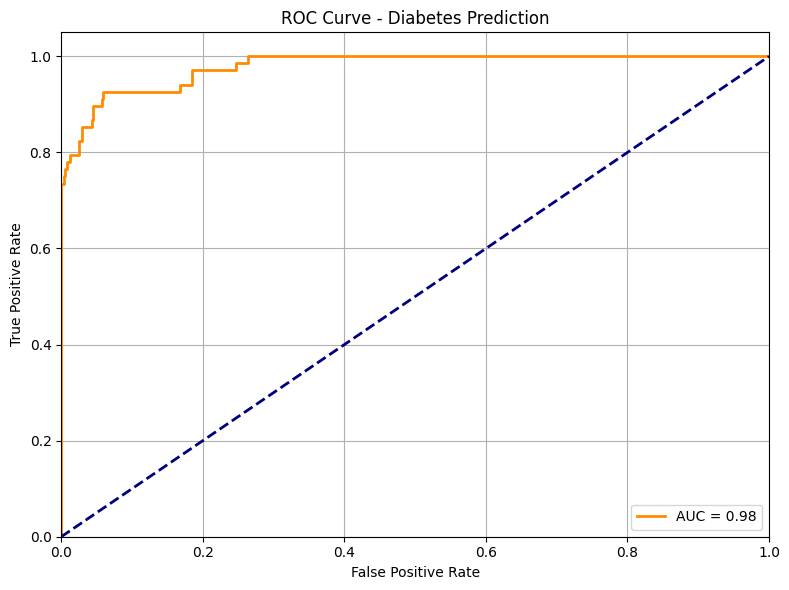

In [39]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Diabetes Prediction')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

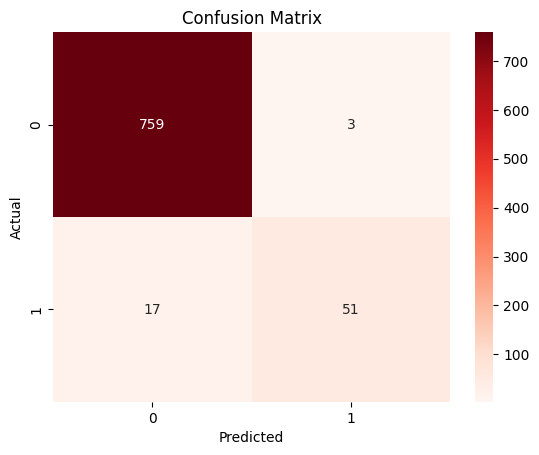

In [40]:
# Confusion Matrix

c_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(c_matrix, annot = True, fmt= 'd', cmap= 'Reds')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       762
           1       0.94      0.75      0.84        68

    accuracy                           0.98       830
   macro avg       0.96      0.87      0.91       830
weighted avg       0.98      0.98      0.97       830



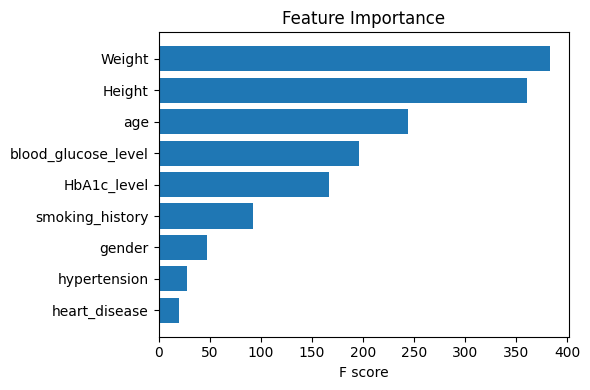

In [42]:
# Feature Importance

feature_names = ['gender', 'age', 'Height', 'Weight', 'hypertension',
                 'heart_disease', 'smoking_history', 'HbA1c_level', 'blood_glucose_level']

booster = model.get_booster()
importance = booster.get_score(importance_type='weight')

importance_named = {feature_names[int(k[1:])]: v for k, v in importance.items()}

sorted_importance = dict(sorted(importance_named.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(6, 4))
plt.barh(list(sorted_importance.keys()), list(sorted_importance.values()))
plt.xlabel("F score")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [43]:
joblib.dump(model, 'xgb_diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']